### White Noise (jitter) in Celerite

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-15-20
<br>**Short description:** This notebook explore the meaning of the `jitter` term in $\texttt{celerite}$ and its correspondence to the measurement noise. 

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [2]:
import celerite
from celerite import GP, terms

# import agntk
from agntk.carma.CARMATerm import *

# import kali
import kali.carma

### 1.0 Test on simulated DRW process
- Simulate a DRW using Kali: 100 days, driving amplitude 0.1 mag
- Add measurement noise ~ 0.05 mag
- Computer logLL using Celerite and see measurement noise

#### 1.1 Simulate LC and plot

In [3]:
# simulate DRW using Kali
drw_task = kali.carma.CARMATask(1,0)
theta = np.array([1/100, 0.1])
drw_task.set(1.0, theta)
drw_lc = drw_task.simulate(duration=3653*10)

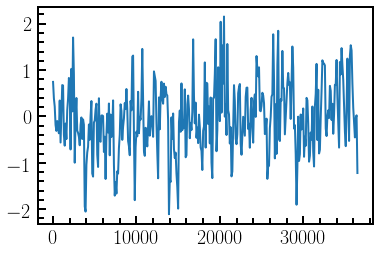

In [4]:
# plot original
plt.plot(drw_lc.t[::100], drw_lc.x[::100])

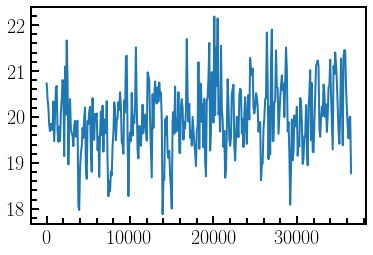

In [5]:
# shift center and add noise
x_err = np.random.normal(0, 0.05, 3653*10)
x = drw_lc.x + x_err
plt.plot(drw_lc.t[::100], x[::100]+20)

#### 1.2 Put into Celerite GP

In [6]:
kernel = DRW_term(np.log(np.sqrt(drw_task.Sigma()[0][0])), np.log(100))
gp = GP(kernel, mean=20)
gp.compute(drw_lc.t, np.abs(x_err))

In [7]:
gp.kernel._has_jitter

False

<span style='color:red'>It turns out that $\texttt{celerite}$ uses the measurement noise to solve the covariance matrix and thus to perform the fitting but the noise is not included as the `jitter` term in the kernel. In addition, the `get_psd()` function does not take use of the measurement noise well </span>

#### 1.2.1 Compare Celeite PSD with CARMA Analytic PSD

In [8]:
# get psd from celerite based normalizatio provided in:
# https://github.com/dfm/celerite/issues/140
t = drw_lc.t
f = np.fft.rfftfreq(len(t), t[1] - t[0])
psd_gp = kernel.get_psd(2*np.pi*f)
psd_gp /=0.5*len(t)

# get CARMA model PSD, divide CARMA psd by N (number of points) to get same
# normalization as Celerite
drw_psd = 0.1**2/((0.01)**2+(2*np.pi*f)**2)/len(t)

/home/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/home/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


Text(0, 0.5, 'PSD (arb units)')

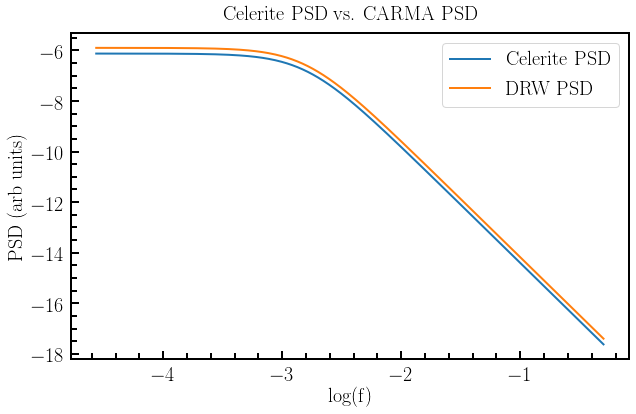

In [10]:
# plot model PSD and celerite psd on one plot
fig = plt.figure(figsize=(10,6))
plt.plot(np.log10(f), np.log(psd_gp), label='Celerite PSD')
plt.plot(np.log10(f), np.log(drw_psd), label='DRW PSD')
plt.legend()
plt.title('Celerite PSD vs. CARMA PSD')
plt.xlabel('log(f)')
plt.ylabel('PSD (arb units)')

**We can see difference in the two PSDs, let's check how large is the residual**

Text(0, 0.5, 'Counts')

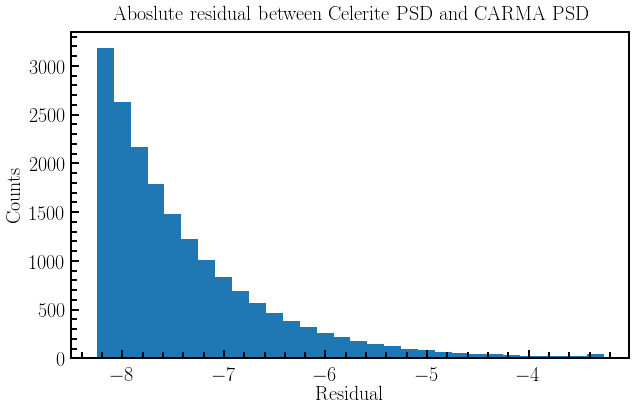

In [11]:
fig = plt.figure(figsize=(10,6))
_ = plt.hist(np.log10(np.abs(drw_psd-psd_gp)))
plt.title('Aboslute residual between Celerite PSD and CARMA PSD')
plt.xlabel('Residual')
plt.ylabel('Counts')